<a href="https://colab.research.google.com/github/Viggy25/boilerplate-cat-and-dog-image-classifier/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-12-25 14:15:57--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   232MB/s    in 0.3s    

2024-12-25 14:15:58 (232 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
# 3

# Create an instance of ImageDataGenerator for training, validation, and testing
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Create the generators using flow_from_directory
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=test_dir,
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode='binary',
                                                        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


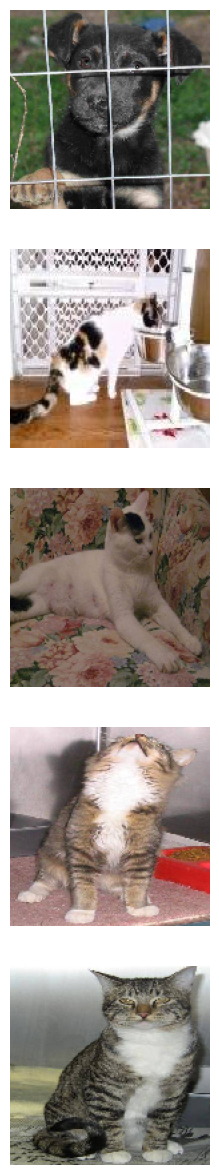

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


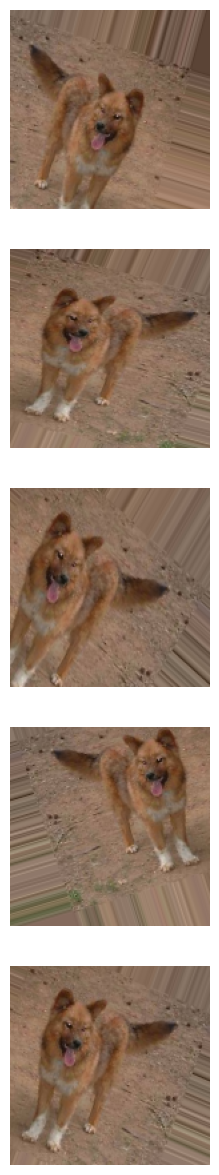

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
#7

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 8
# Use the fit method on your model to train the network.
# Make sure to pass in arguments for x, steps_per_epoch, epochs, validation_data, and validation_steps.

history = model.fit(
    x=train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.4835 - loss: 1.4349 - val_accuracy: 0.5525 - val_loss: 0.6909
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - accuracy: 0.6094 - loss: 0.6913

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6094 - loss: 0.6913 - val_accuracy: 0.5577 - val_loss: 0.6805
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.5102 - loss: 0.6933 - val_accuracy: 0.6339 - val_loss: 0.6891
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5312 - loss: 0.6924 - val_accuracy: 0.6058 - val_loss: 0.6895
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.5671 - loss: 0.6899 - val_accuracy: 0.5201 - val_loss: 0.6738
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5859 - loss: 0.6759 - val_accuracy: 0.6538 - val_loss: 0.6262
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.5461 - loss: 0.6765 - val_accuracy: 0.6116 - val_loss: 0.6470
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6094 - loss: 0.6708 - val_accuracy: 0.5577 - val_loss: 0.7191
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.5580 - loss: 0.6852 - val_accuracy: 0.5379 - val_loss: 0.

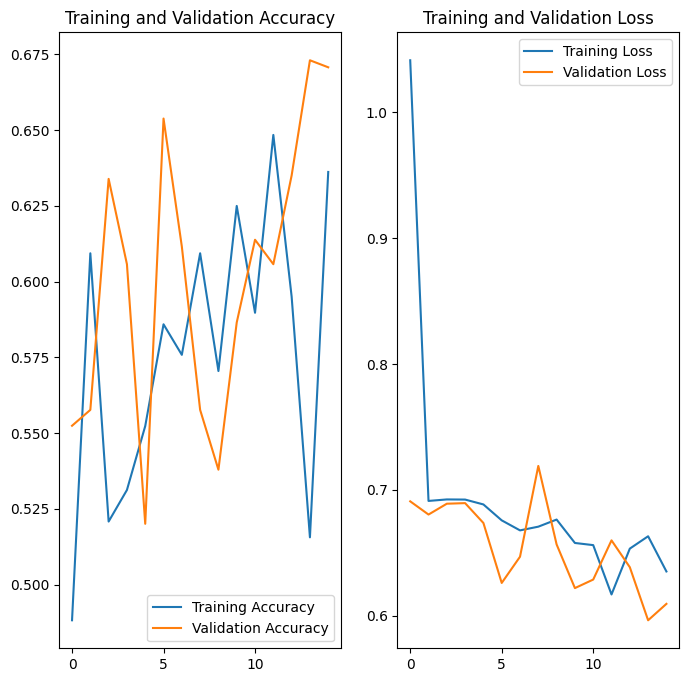

In [9]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
import numpy as np

# Check if the test set is empty
if len(test_data_gen.filenames) == 0:
    print("Error: No test samples found.")
else:
    # Reset the test data generator
    test_data_gen.reset()

    # Get predictions using evaluate_generator (for older TensorFlow/Keras versions)
    # Or use model.evaluate for newer versions
    # loss, probabilities = model.evaluate_generator(test_data_gen, steps=len(test_data_gen), verbose=0)
    loss, probabilities = model.evaluate(test_data_gen, verbose=0)

    # Convert probabilities to class labels (0 for cat, 1 for dog)
    predicted_classes = (probabilities > 0.5).astype(int)

    # Print the predictions
    print("Predictions:")
    for i, prediction in enumerate(predicted_classes):
        print(f"Image {i + 1}: {'Dog' if prediction == 1 else 'Cat'}")

Error: No test samples found.


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Check if the test set is empty
if len(test_data_gen.filenames) == 0:
    print("Error: No test samples found.")
else:
    # Reset the test data generator
    test_data_gen.reset()

    # Get predictions using evaluate
    loss, probabilities = model.evaluate(test_data_gen, verbose=0)

    # Convert probabilities to class labels (0 for cat, 1 for dog)
    predicted_classes = (probabilities > 0.5).astype(int)

    # Print the predictions
    print("Predictions:")
    for i, prediction in enumerate(predicted_classes):
        print(f"Image {i + 1}: {'Dog' if prediction == 1 else 'Cat'}")

    # Get test images and their probabilities
    test_images, _ = next(test_data_gen)  # Get a batch of test images
    num_images_to_plot = min(len(test_images), len(probabilities))  # Ensure enough probabilities
    test_images = test_images[:num_images_to_plot]
    probabilities_to_plot = probabilities[:num_images_to_plot]

    # Call plotImages with test images and probabilities
    plotImages(test_images, probabilities_to_plot)

Error: No test samples found.


In [21]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
